In [ ]:
from time import sleep
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import openrouteservice as ors

In [2]:
df = pd.read_csv("data/2023/Divvy_Trips_2023_full.csv.gz", compression="gzip")

# Общая информация о датасете

In [3]:
df.head()

,ride_id,rideable_type,started_at,ended_at,start_station_name,start_station_id,end_station_name,end_station_id,start_lat,start_lng,end_lat,end_lng,member_casual
0,F96D5A74A3E41399,electric_bike,2023-01-21 20:05:42,2023-01-21 20:16:33,Lincoln Ave & Fullerton Ave,TA1309000058,Hampden Ct & Diversey Ave,202480.0,41.924074,-87.646278,41.930000,-87.640000,member
1,13CB7EB698CEDB88,classic_bike,2023-01-10 15:37:36,2023-01-10 15:46:05,Kimbark Ave & 53rd St,TA1309000037,Greenwood Ave & 47th St,TA1308000002,41.799568,-87.594747,41.809835,-87.599383,member
2,BD88A2E670661CE5,electric_bike,2023-01-02 07:51:57,2023-01-02 08:05:11,Western Ave & Lunt Ave,RP-005,Valli Produce - Evanston Plaza,599,42.008571,-87.690483,42.039742,-87.699413,casual
3,C90792D034FED968,classic_bike,2023-01-22 10:52:58,2023-01-22 11:01:44,Kimbark Ave & 53rd St,TA1309000037,Greenwood Ave & 47th St,TA1308000002,41.799568,-87.594747,41.809835,-87.599383,member
4,3397017529188E8A,classic_bike,2023-01-12 13:58:01,2023-01-12 14:13:20,Kimbark Ave & 53rd St,TA1309000037,Greenwood Ave & 47th St,TA1308000002,41.799568,-87.594747,41.809835,-87.599383,member


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 639424 entries, 0 to 639423
Data columns (total 13 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   ride_id             639424 non-null  object 
 1   rideable_type       639424 non-null  object 
 2   started_at          639424 non-null  object 
 3   ended_at            639424 non-null  object 
 4   start_station_name  551320 non-null  object 
 5   start_station_id    551188 non-null  object 
 6   end_station_name    546408 non-null  object 
 7   end_station_id      546267 non-null  object 
 8   start_lat           639424 non-null  float64
 9   start_lng           639424 non-null  float64
 10  end_lat             638998 non-null  float64
 11  end_lng             638998 non-null  float64
 12  member_casual       639424 non-null  object 
dtypes: float64(4), object(9)
memory usage: 63.4+ MB


## Работа с данными

In [5]:
# Выбор нужных колонок датасета - координаты, название и id станций

# Данные начальных станций
station_names = df[["start_station_name"]]
station_names = station_names.rename(columns={"start_station_name": "station_name"})

# Данные конечных станций
station_end_names = df[["end_station_name"]]
station_end_names = station_end_names.rename(
    columns={"end_station_name": "station_name"}
)

In [6]:
# Склейка данных в 1 датасет
station_names = pd.concat([station_names, station_end_names])

In [7]:
station_names

,station_name
0,Lincoln Ave & Fullerton Ave
1,Kimbark Ave & 53rd St
2,Western Ave & Lunt Ave
3,Kimbark Ave & 53rd St
4,Kimbark Ave & 53rd St
...,...
639419,Canal St & Adams St
639420,Sheridan Rd & Buena Ave
639421,Broadway & Waveland Ave
639422,Broadway & Waveland Ave


## Подсчет популярности отдельных станций

In [8]:
# Расчитаем количество повторений каждой станции
popular_station = pd.DataFrame(station_names["station_name"].value_counts())

In [9]:
# Возвращаем индексы и переназываем столбцы
popular_station = popular_station.reset_index()
popular_station.columns = ["station_name", "count"]

popular_station.head()

,station_name,count
0,University Ave & 57th St,11816
1,Ellis Ave & 60th St,11373
2,Clinton St & Washington Blvd,10732
3,Kingsbury St & Kinzie St,9808
4,Clark St & Elm St,8716


In [ ]:
station_coord = popular_station.head(25)

station_coord.rename(
    columns={"station_name": "start_name", "count": "count"},
    inplace=True,
)

In [ ]:
station_coord

In [ ]:
# Для начала нужно получить координаты для всех станций
coord = pd.read_csv("data/2023/station_coord.csv")

In [ ]:
coord.drop(columns=["end_station_id"], inplace=True)

In [ ]:
coord.rename(
    columns={"station_name": "start_name", "lng": "start_lng", "lat": "start_lat"},
    inplace=True,
)

In [ ]:
station_coord = station_coord.merge(coord, how="left", on="start_name")

station_coord.head()

## Самые популярные станции на карте

In [ ]:
coord_map = station_coord.values.tolist()

In [ ]:
import folium
from folium.plugins import MarkerCluster


chicago = folium.Map(location=[41.85, -87.65], zoom_start=11)

marker_cluster = MarkerCluster().add_to(chicago)


for i in coord_map:
    folium.CircleMarker(
        location=(i[3], i[2]),
        fill_color="#990066",
        color="gray",
        fill_opacity=0.9,
        popup=f"Name:{i[0]} \nID: {i[3]} ",
    ).add_to(marker_cluster)

chicago

## Самые популярные маршруты

In [10]:
trip = df[["start_station_name", "end_station_name"]]

In [11]:
# Расчитаем количество повторений каждого маршрута
popular_trip = pd.DataFrame(
    trip[["start_station_name", "end_station_name"]].value_counts()
)

In [12]:
# Возвращаем индексы и переназываем столбцы
popular_trip = popular_trip.reset_index()
popular_trip.columns = ["start_name", "stop_name", "count"]

popular_trip.head()

,start_name,stop_name,count
0,Ellis Ave & 60th St,University Ave & 57th St,2022
1,University Ave & 57th St,Ellis Ave & 60th St,1921
2,Ellis Ave & 60th St,Ellis Ave & 55th St,1760
3,Ellis Ave & 55th St,Ellis Ave & 60th St,1660
4,Loomis St & Lexington St,Morgan St & Polk St,832


## Расстояние
Посчитаем расстояние для топ-300 популярных маршрутов используя внешнее API

In [13]:
# Для начала нужно получить координаты для всех станций
coord = pd.read_csv("data/2023/station_coord.csv")

In [14]:
coord.head()

,station_name,lng,lat,end_station_id
0,Lincoln Ave & Fullerton Ave,-87.667968,41.914610,TA1309000058
1,Kimbark Ave & 53rd St,-87.594747,41.799568,TA1309000037
2,Western Ave & Lunt Ave,-87.700825,41.965875,RP-005
3,Lakeview Ave & Fullerton Pkwy,-87.648556,41.949097,TA1309000019
4,Broadway & Waveland Ave,-87.648577,41.949088,13325


In [15]:
coord.drop(columns=["end_station_id"], inplace=True)

In [16]:
coord.rename(
    columns={"station_name": "start_name", "lng": "start_lng", "lat": "start_lat"},
    inplace=True,
)

In [17]:
coord.head()

,start_name,start_lng,start_lat
0,Lincoln Ave & Fullerton Ave,-87.667968,41.914610
1,Kimbark Ave & 53rd St,-87.594747,41.799568
2,Western Ave & Lunt Ave,-87.700825,41.965875
3,Lakeview Ave & Fullerton Pkwy,-87.648556,41.949097
4,Broadway & Waveland Ave,-87.648577,41.949088


In [18]:
# Возьмем топ-300 популярных маршрутов чтобы не ждать долго
top_300 = popular_trip.head(300)

In [19]:
top_300.head()

,start_name,stop_name,count
0,Ellis Ave & 60th St,University Ave & 57th St,2022
1,University Ave & 57th St,Ellis Ave & 60th St,1921
2,Ellis Ave & 60th St,Ellis Ave & 55th St,1760
3,Ellis Ave & 55th St,Ellis Ave & 60th St,1660
4,Loomis St & Lexington St,Morgan St & Polk St,832


In [20]:
top_300 = top_300.merge(coord, how="left", on="start_name")

In [21]:
coord.rename(
    columns={
        "start_name": "stop_name",
        "start_lng": "stop_lng",
        "start_lat": "stop_lat",
    },
    inplace=True,
)

In [22]:
top_300 = top_300.merge(coord, how="left", on="stop_name")

In [23]:
top_300.head()

,start_name,stop_name,count,start_lng,start_lat,stop_lng,stop_lat
0,Ellis Ave & 60th St,University Ave & 57th St,2022,-87.594747,41.799568,-87.594750,41.799550
1,University Ave & 57th St,Ellis Ave & 60th St,1921,-87.594750,41.799550,-87.594747,41.799568
2,Ellis Ave & 60th St,Ellis Ave & 55th St,1760,-87.594747,41.799568,-87.594747,41.799568
3,Ellis Ave & 55th St,Ellis Ave & 60th St,1660,-87.594747,41.799568,-87.594747,41.799568
4,Loomis St & Lexington St,Morgan St & Polk St,832,-87.623041,41.867888,-87.654144,41.855135


In [24]:
API_KEY = os.environ.get("ORS_KEY")
ors_client = ors.Client(key=API_KEY)

In [25]:
def get_route_length(origin, destination):
    # Задержка для того чтобы не превысить лимит запросов
    sleep(2)
    # Отправляем запрос на сервер и получаем ответ в формате JSON
    response = ors_client.directions(
        coordinates=[origin, destination], profile="cycling-regular", format="json"
    )

    # Извлекаем длину маршрута из ответа если маршрут получен
    if response["routes"][0]["summary"] != {}:
        route_length = response["routes"][0]["summary"]["distance"]
    else:
        route_length = None
    # Возвращаем длину маршрута в метрах
    return route_length

In [26]:
# Добавляем столбец с расстоянием посчитанным для каждого маршрута
top_300["distance"] = top_300.apply(
    lambda x: get_route_length(
        (x["start_lng"], x["start_lat"]), (x["stop_lng"], x["stop_lat"])
    ),
    axis=1,
)

In [27]:
# Убираем пустые значения
top_300 = top_300.sort_values(by="distance", ascending=False).dropna(
    subset=["distance"]
)

In [28]:
top_300.head()

,start_name,stop_name,count,start_lng,start_lat,stop_lng,stop_lat,distance
269,Clinton St & Lake St,Canal St & Adams St,114,-87.648627,41.949067,-87.623057,41.867880,11418.0
159,Clinton St & Lake St,Clinton St & Jackson Blvd,139,-87.648627,41.949067,-87.623041,41.867888,11417.1
224,Halsted St & Wrightwood Ave,Wilton Ave & Diversey Pkwy,121,-87.648542,41.949085,-87.623043,41.867916,11370.0
147,Canal St & Adams St,Clinton St & Lake St,143,-87.623057,41.867880,-87.648627,41.949067,11339.0
82,Clinton St & Jackson Blvd,Clinton St & Lake St,180,-87.623041,41.867888,-87.648627,41.949067,11338.2


In [30]:
top_300.to_csv("data/2023/top_300_paths.csv", index=False)

In [19]:
top_300 = pd.read_csv("data/2023/top_300_paths.csv")

Text(0.5, 1.0, 'Зависимость количества поездок от расстояния между станциями')

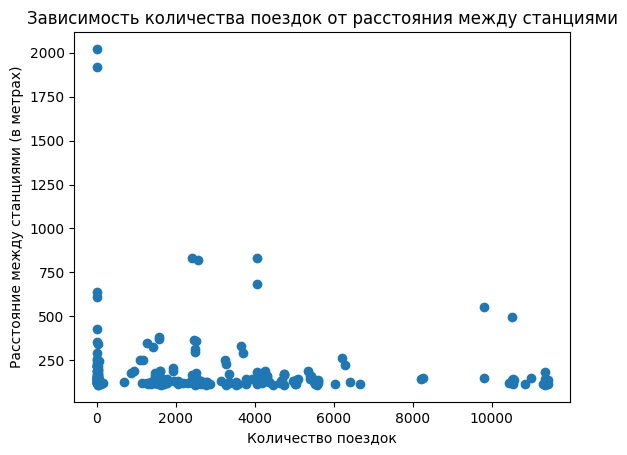

In [20]:
plt.scatter(top_300["distance"], top_300["count"])
plt.xlabel("Количество поездок")
plt.ylabel("Расстояние между станциями (в метрах)")
plt.title("Зависимость количества поездок от расстояния между станциями")